In [0]:
!pip install tensorflow-gpu==2

In [0]:
import io
import os
import re
import time
import unicodedata

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

### Download and preprocess the dataset

In [0]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"

In [0]:
# Converts a unicode file to ascii.
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # Insert a space before punctuations following a character.
    # "he is a boy." -> "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # Replace everything with space except (a-z, A-Z, ".", "?", "!", ",").
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # Add a start and an end token to the sentence
    # so that the model knows when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [49]:
# Example
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print("Preprocessed English sentence:\n\t",
      repr(preprocess_sentence(en_sentence)))
print("Preprocessed Spanish sentence:\n\t",
      repr(preprocess_sentence(sp_sentence)))
print("Preprocessed Spanish sentence (encoded):\n\t",
      repr(preprocess_sentence(sp_sentence).encode('utf-8')))

Preprocessed English sentence:
	 '<start> may i borrow this book ? <end>'
Preprocessed Spanish sentence:
	 '<start> ¿ puedo tomar prestado este libro ? <end>'
Preprocessed Spanish sentence (encoded):
	 b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'
Preprocessed English sentence:
	 '<start> may i borrow this book ? <end>'
Preprocessed Spanish sentence:
	 '<start> ¿ puedo tomar prestado este libro ? <end>'
Preprocessed Spanish sentence (encoded):
	 b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [0]:
# 1. Remove the accents.
# 2. Clean the sentences.
# 3. Return sentence pairs in the format: (ENGLISH, SPANISH)
def create_dataset(path, num_examples):
    with io.open(path, encoding='utf-8') as f:
        lines = f.read().strip().splitlines()
    
    word_pairs = [[preprocess_sentence(w) for w in line.split('\t')]
                  for line in lines[:num_examples]]
    return zip(*word_pairs)

In [51]:
en_sentences, sp_sentences = create_dataset(path_to_file, None)
print(en_sentences[0])
print(sp_sentences[0])
print('-'*20)
print(en_sentences[-1])
print(sp_sentences[-1])

<start> go . <end>
<start> ve . <end>
--------------------
<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>
<start> go . <end>
<start> ve . <end>
--------------------
<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto 

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(texts):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(texts)
    tensor = tokenizer.texts_to_sequences(texts)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                           padding='post')
    return tensor, tokenizer

def load_dataset(path, num_examples=None):
    target_sentences, input_sentences = create_dataset(path, num_examples)
    target_tensor, target_tokenizer = tokenize(target_sentences)
    input_tensor, input_tokenizer = tokenize(input_sentences)
    return input_tensor, target_tensor, input_tokenizer, target_tokenizer

Limit the size of the dataset to experiment faster.

In [0]:
input_tensor, target_tensor, input_tokenizer, target_tokenizer = \
    load_dataset(path_to_file, num_examples=30000)

max_length_input = max_length(input_tensor)
max_length_target = max_length(target_tensor)

In [54]:
print("Input tensor shape:", input_tensor.shape)
print("Target tensor shape:", target_tensor.shape)
print("Max length input:", max_length_input)
print("Max length target:", max_length_target)

Input tensor shape: (30000, 16)
Target tensor shape: (30000, 11)
Max length input: 16
Max length target: 11
Input tensor shape: (30000, 16)
Target tensor shape: (30000, 11)
Max length input: 16
Max length target: 11


In [55]:
# Split train/valid sets.
(input_tensor_train, input_tensor_valid,
 target_tensor_train, target_tensor_valid) = train_test_split(input_tensor,
                                                              target_tensor,
                                                              test_size=0.2)
print("# of training input tensors:", len(input_tensor_train))
print("# of training target tensors:", len(target_tensor_train))
print("# of validation input tensors:", len(input_tensor_valid))
print("# of validation target tensors:", len(target_tensor_valid))

# of training input tensors: 24000
# of training target tensors: 24000
# of validation input tensors: 6000
# of validation target tensors: 6000
# of training input tensors: 24000
# of training target tensors: 24000
# of validation input tensors: 6000
# of validation target tensors: 6000


Peek some index-to-word mapping.

In [0]:
def convert(tokenizer, vector):
    for idx in vector:
        if idx:
            print("{} ----> {}".format(idx,
                                       tokenizer.index_word[idx]))

In [57]:
print("Input language: index to word mapping")
convert(input_tokenizer, input_tensor_train[0])
print()
print("Target language: index to word mapping")
convert(target_tokenizer, target_tensor_train[0])

Input language: index to word mapping
1 ----> <start>
505 ----> sois
107 ----> mis
212 ----> amigos
3 ----> .
2 ----> <end>

Target language: index to word mapping
1 ----> <start>
6 ----> you
23 ----> re
21 ----> my
247 ----> friends
3 ----> .
2 ----> <end>
Input language: index to word mapping
1 ----> <start>
619 ----> seria
15 ----> un
1655 ----> desastre
3 ----> .
2 ----> <end>

Target language: index to word mapping
1 ----> <start>
10 ----> it
194 ----> d
40 ----> be
9 ----> a
1795 ----> disaster
3 ----> .
2 ----> <end>


Create a `tf.data.Dataset`

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
rnn_units = 1024
vocab_input_size = len(input_tokenizer.word_index) + 1
vocab_target_size = len(target_tokenizer.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices(
    (input_tensor_train, target_tensor_train)
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [59]:
# Example
example_input_batch, example_target_batch = next(iter(dataset))
print("Input batch shape:", example_input_batch.shape)
print("Target batch shape:", example_target_batch.shape)

Input batch shape: (64, 16)
Target atch shape: (64, 11)
Input batch shape: (64, 16)
Target atch shape: (64, 11)


### The encoder & decoder model

![](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg)

The input is put through the encoder, which gives the encoder output of shape `(batch_size, max_length, hidden_size)` and the encoder hidden state of shape `(batch_size, hidden_size)`.

---

Source hidden states: $\bar{\mathbf{h}}_s\ (s\in S)$

Target hidden state (at timestep $t$): $\mathbf{h}_t$

Scores between the source states and target state:

$\quad \mathrm{score}\left(\mathbf{h}_t, \bar{\mathbf{h}}_s\right) = \begin{cases} \mathbf{h}_t^\top\mathbf{W}\bar{\mathbf{h}}_s \quad\text{(Luong's multiplicative style)}\\ \mathbf{v}_a^\top \tanh{\left( \mathbf{W}_1\mathbf{h}_t + \mathbf{W}_2\bar{\mathbf{h}}_s \right)} \quad\text{(Bahdanau's additive style)} \end{cases}$

Attention weights:

$\quad \alpha_{ts} = \frac{\exp{\left(\mathrm{score}\left(\mathbf{h}_t, \bar{\mathbf{h}}_s\right) \right)}}{\sum_{s'\in S} \exp{\left(\mathrm{score}\left(\mathbf{h}_t, \bar{\mathbf{h}}_{s'} \right)\right)}}$

Context vector:

$\quad \mathbf{c}_t = \sum_s \alpha_{ts} \bar{\mathbf{h}}_s$

Attention vector:

$\quad \mathbf{a}_t = f\left(\mathbf{c}_t, \mathbf{h}_t\right) = \tanh{\left( \mathbf{W}_c \left[\mathbf{c}_t; \mathbf{h}_t\right]\right)}$

---

Here we use [Bahdanau attention](https://arxiv.org/abs/1409.0473) for calculating the scores.

Recall [[Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn#bidirectional_rnns)]:
* Be default, an RNN layer outputs *per sample* the last cell output of shape `(batch_size, units)`.
* With `return_sequences=True`, the entire sequence of outputs are given, with shape `(batch_size, timesteps, units)`.
* With `return_state=True`, an RNN layer's final internal state can be taken. Note that an LSTM has two state tensors whereas a GRU has one. In an encoder–decoder model, the final state of the encoder is used as the initial state of the decoder, with argument `initial_state`.

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size,
                                                   embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
    
    def call(self, x, hidden):
        # Shape -> (batch_size, max_length, embedding_dim)
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_units))

In [92]:
encoder = Encoder(vocab_input_size, embedding_dim, rnn_units, BATCH_SIZE)

# Sample
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch,
                                       sample_hidden)

print("Example input batch shape:", example_input_batch.shape)
print("Encoder output shape:", sample_output.shape,
      "# (batch_size, sequence_length, rnn_units)")
print("Encoder state shape:", sample_hidden.shape,
      "# (batch_size, rnn_units)")

Example input batch shape: (64, 16)
Encoder output shape: (64, 16, 1024) # (batch_size, sequence_length, rnn_units)
Encoder state shape: (64, 1024) # (batch_size, rnn_units)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, attn_units):
        """attn_units: hidden units used WITHIN this layer.
            Independent from the RNN hidden units.
        """
        super().__init__()
        self.W1 = tf.keras.layers.Dense(attn_units)
        self.W2 = tf.keras.layers.Dense(attn_units)
        self.V = tf.keras.layers.Dense(1)
    
    def call(self, query, values):
        """\
        query: decoder hidden state
            (batch_size, rnn_units)
        values: the sequence of encoder outputs
            (batch_size, max_length, rnn_units)
        """
        # Shape -> (batch_size, 1, rnn_units)
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # Shape before `self.V` -> (batch_size, max_length, attn_units)
        # Shape after `self.V` -> (batch_size, max_length, 1)
        # the last is the shape of `score`.
        score = self.V(tf.nn.tanh(
            # I think W1 and W2 need to be switched to follow the document,
            # though the result does not change.
            self.W1(values) + self.W2(hidden_with_time_axis)
        ))

        # attention_weights shape = (batch_size, max_length, 1)
        # Take softmax over the timestep axis.
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape = (batch_size, rnn_units)
        context_vector = tf.reduce_sum(
            attention_weights * values,
            axis=1
        )

        return context_vector, attention_weights

In [93]:
attention_layer = BahdanauAttention(10)
context_vector, attention_weights = attention_layer(sample_hidden,
                                                    sample_output)

print("Context vector shape:", context_vector.shape,
      "# (batch_size, rnn_units)")
print("Attention weights shape:", attention_weights.shape,
      "# (batch_size, max_length, 1)")

Context vector shape: (64, 1024) # (batch_size, rnn_units)
Attention weights shape: (64, 16, 1) # (batch_size, max_length, 1)


In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size,
                                                   embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)
    
    def call(self, x, hidden, enc_output):
        """\
        x: (batch_size, 1 (single word, or timesstep))
        enc_output: (batch_size, max_length, hidden_size)
        """
        # context_vector -> (batch_size, rnn_units)
        # attention_weights -> (batch_size, max_length, 1)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # Shape -> (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # Shape -> (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)

        # (batch_size, 1, hidden_size) -> (batch_size*1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # Shape -> (batch_size, vocab_size)
        x = self.fc(output)

        return x, state, attention_weights

In [98]:
decoder = Decoder(vocab_target_size, embedding_dim, rnn_units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden,
                                      sample_output)

print("Decoder output shape:", sample_decoder_output.shape,
      "# (batch_size, vocab_target_size)")

Decoder output shape: (64, 4935) # (batch_size, vocab_target_size)


### Optimizer and loss

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

def loss_function(true, pred):
    mask = tf.math.logical_not(tf.math.equal(true, 0))
    losses = loss_object(true, pred)

    # To a new type
    mask = tf.cast(mask, dtype=losses.dtype)
    losses *= mask

    loss = tf.reduce_mean(losses)
    return loss

### Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Training

1. Pass *input* to *encoder* and get *encoder output* and *encoder state*.
2. Pass the *encoder output*, *encoder state* and *decoder input* (the *start token*) to *decoder*.
3. *Decoder* returns *predictions* and *decoder state*.
4. Pass the *decoder state* back into the model, and use *predictions* to calculate the loss.
5. Use *teacher forcing* to decider the next input to *decoder*.
6. At the final timestep, calculate the gradients and backpropagate.

In [0]:
@tf.function
def train_step(inp, target, enc_state):
    loss = 0.

    with tf.GradientTape() as tape:
        enc_output, enc_state = encoder(inp, enc_state)
        dec_state = enc_state
        dec_input = tf.expand_dims(
            [target_tokenizer.word_index['<start>']] * BATCH_SIZE,
            1
        )  # -> (batch_size, 1 (single word, or timestep))

        # Teacher forcing: feed the target as the next input to decoder.
        for t in range(1, target.shape[1]):
            predictions, dec_state, _ = decoder(dec_input,
                                                dec_state,
                                                enc_output)
            loss += loss_function(target[:,t], predictions)
            # Teacher forcing
            dec_input = tf.expand_dims(target[:,t], 1)
    
    batch_loss = loss / int(target.shape[1])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [107]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_state = encoder.initialize_hidden_state()
    total_loss = 0.

    for batch_n, (inp, target) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, target, enc_state)
        total_loss += batch_loss

        if not batch_n % 100:
            print("Epoch {} Batch {} Loss {:.4f}".format(epoch,
                                                          batch_n,
                                                          batch_loss.numpy()))
    
    # Save the model every 2 epochs
    if not (epoch + 1) % 2:
        checkpoint.save(file_prefix=checkpoint_prefix)
    
    print("Epoch {} Loss {:.4f}".format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print("Time taken for 1 epoch: {} sec".format(time.time() - start))
    print()

Epoch 0 Batch 0 Loss 4.5544
Epoch 0 Batch 100 Loss 2.2516
Epoch 0 Batch 200 Loss 1.8496
Epoch 0 Batch 300 Loss 1.7303
Epoch 1 Loss 2.0198
Time taken for 1 epoch: 42.89061903953552 sec

Epoch 1 Batch 0 Loss 1.5171
Epoch 1 Batch 100 Loss 1.5595
Epoch 1 Batch 200 Loss 1.3798
Epoch 1 Batch 300 Loss 1.2653
Epoch 2 Loss 1.3530
Time taken for 1 epoch: 30.63962459564209 sec

Epoch 2 Batch 0 Loss 1.1000
Epoch 2 Batch 100 Loss 0.9569
Epoch 2 Batch 200 Loss 0.7753
Epoch 2 Batch 300 Loss 0.8831
Epoch 3 Loss 0.9227
Time taken for 1 epoch: 30.583922624588013 sec

Epoch 3 Batch 0 Loss 0.6862
Epoch 3 Batch 100 Loss 0.6287
Epoch 3 Batch 200 Loss 0.6164
Epoch 3 Batch 300 Loss 0.6574
Epoch 4 Loss 0.6117
Time taken for 1 epoch: 30.806904315948486 sec

Epoch 4 Batch 0 Loss 0.3815
Epoch 4 Batch 100 Loss 0.4238
Epoch 4 Batch 200 Loss 0.3958
Epoch 4 Batch 300 Loss 0.5178
Epoch 5 Loss 0.4104
Time taken for 1 epoch: 30.49425172805786 sec

Epoch 5 Batch 0 Loss 0.2461
Epoch 5 Batch 100 Loss 0.2505
Epoch 5 Batch 2

### Translate

* `evaluate` below is similar to the training loop, but we don't use *teacher forcing* anymore. The input to the decoder at each timestep is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts *end token*.
* We'll store the attention weights for every timestep, for plotting afterwards.
* The encoder output is calculated only once to get one input.

In [0]:
def evaluate(sentence):
    # For plotting afterwards.
    attention_plot = np.zeros((max_length_target, max_length_input))

    sentence = preprocess_sentence(sentence)
    inputs = [input_tokenizer.word_index[i] for i in sentence.split()]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_input,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)  # (1, max_length_input)
    hidden = [tf.zeros((1, rnn_units))]  # Initial

    # Run the encoder only once.
    enc_output, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']], 0)
    # -> (1, max_length_target)

    result = ''
    for t in range(max_length_target):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_output)
        
        # Store the attention weights.
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_plot[t] = attention_weights.numpy()

        predicted_idx = tf.argmax(predictions[0]).numpy()
        predicted_word = target_tokenizer.index_word[predicted_idx]
        result += predicted_word + ' '

        # The end token
        if predicted_word == '<end>':
            return result, sentence, attention_plot
        else:
            # Feed the predicted index back into the model.
            dec_input = tf.expand_dims([predicted_idx], 0)  # (1, 1)

    return result, sentence, attention_plot

In [0]:
def plot_attention(attention_matrix, sentence: list, prediction: list):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1,1,1)
    ax.matshow(attention_matrix, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + prediction, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print(f"Input:\n\t{sentence}")
    print(f"Translation:\n\t{result}")

    attention_plot = attention_plot[:len(result.split()), :len(sentence.split())]
    plot_attention(attention_plot, sentence.split(), result.split())

### Restore the last checkpoint and test the model

In [113]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

enc_output shape: (1, 16, 1024)
Input:
	<start> hace mucho frio aqui . <end>
Translation:
	it s very cold here . <end> 


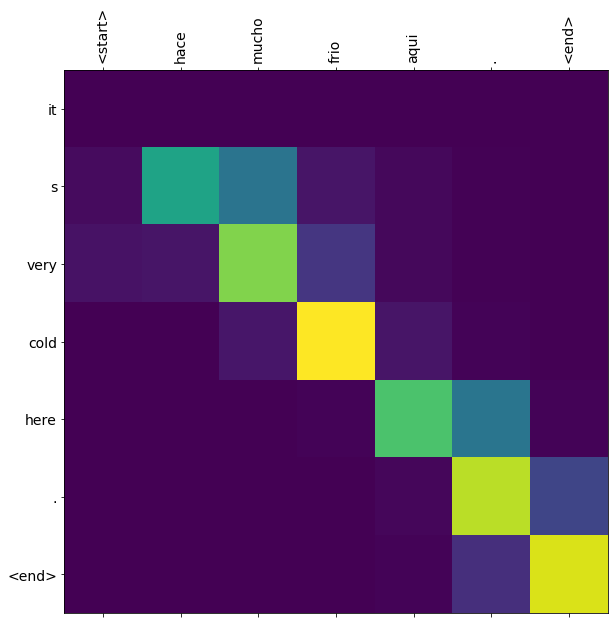

In [147]:
translate(u'hace mucho frio aqui.')

Input:
	<start> esta es mi vida . <end>
Translation:
	this is my life . <end> 


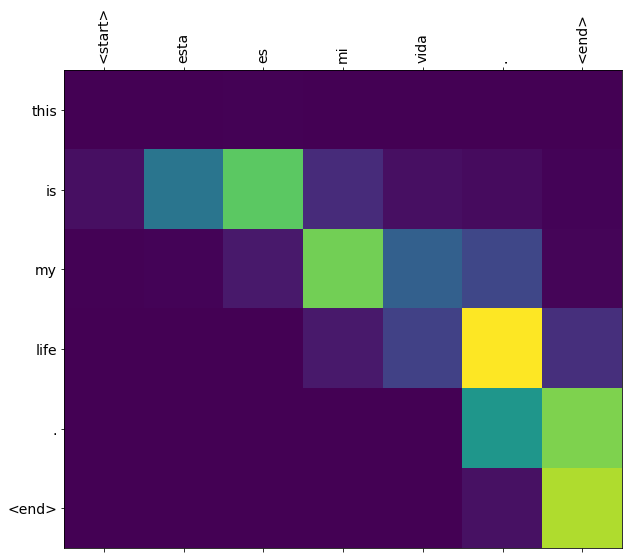

In [141]:
translate(u'esta es mi vida.')

Input:
	<start> ¿ todavia estan en casa ? <end>
Translation:
	are you still at home ? <end> 


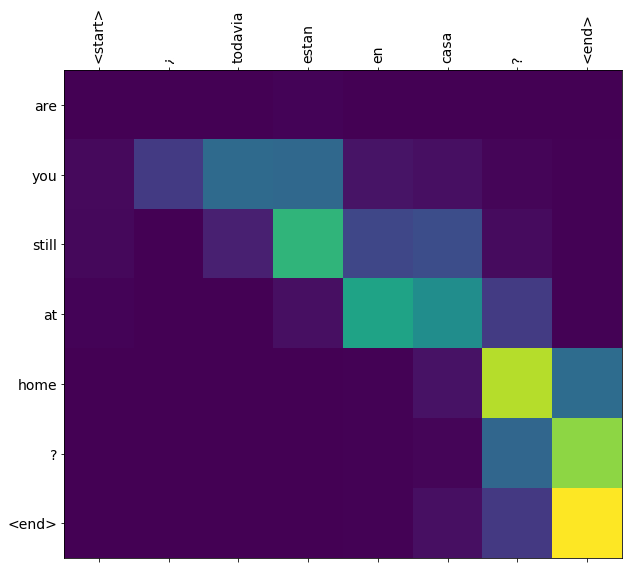

In [142]:
translate(u'¿todavia estan en casa?')

Input:
	<start> trata de averiguarlo . <end>
Translation:
	try to figure it out . <end> 


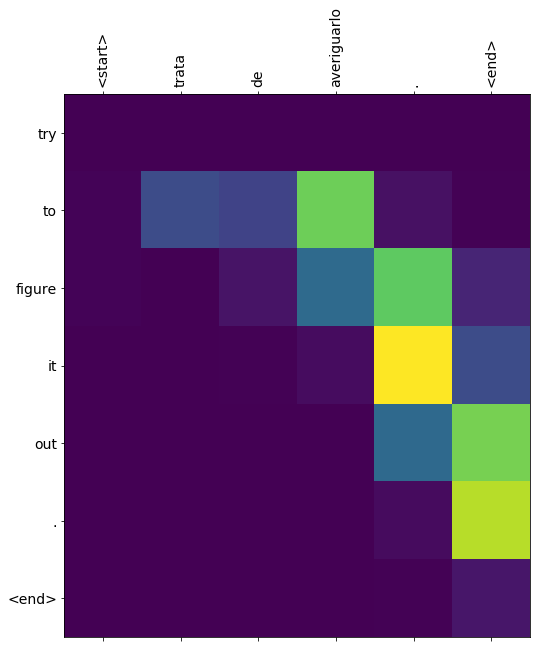

In [143]:
# Wrong translation example
translate(u'trata de averiguarlo.')